# Estimate parameters of the model in 5_Miyazaki

### pre-setting

In [1]:
%load_ext Cython
import scipy.stats as stats 
from scipy.stats import norm
from scipy.stats import gamma
import matplotlib.pyplot as plt 
%matplotlib inline 
import pandas as pd 
import numpy as np
import re 
import os


import time 
from datetime import datetime


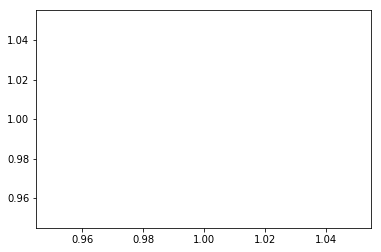

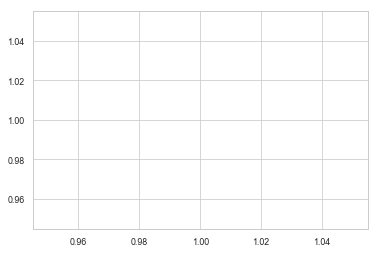

In [2]:
plt.plot(1,1)
plt.show()
import seaborn as sns
sns.set(context="paper" , style ="whitegrid",rc={"figure.facecolor":"white"})
plt.plot(1,1)

# Implementation part  

In [3]:
t = np.linspace(0,20,200)
tau = t[1] - t[0]
def pr_all(a=5,b =2,bins = 200,beta = 50,PReward =0.25 ):
    gm = gamma(a=a,loc = 1/b)
    y = gm.pdf(t)
    yy = 1 - gm.cdf(t)
    # probability of quitting 
    PPosterior = PReward*yy/( PReward*yy + 1-PReward  )
    PWait =   1 / (1 + np.exp(-beta*PPosterior))
    Pwaitings = [1]
    Pquit = []
    for pw in PWait:
        Pquit.append(Pwaitings[-1]*(1-pw))
        Pwaitings.append(Pwaitings[-1]*pw)
    total = np.sum(Pquit)
    plt.plot(t,Pquit/total,label=str(PReward))
    print(tau)

0.10050251256281408


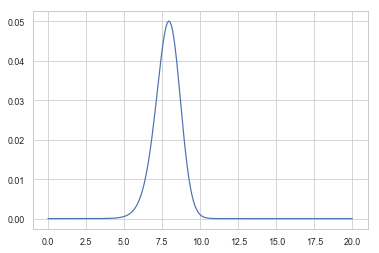

In [4]:
pr_all()

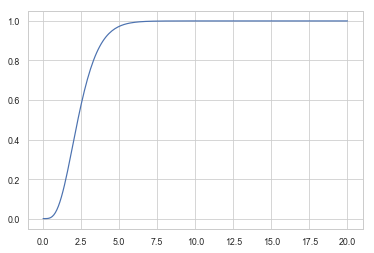

In [5]:
a = 5
b = 2
t = np.linspace(0,20,200)
tau = t[1] - t[0]
gm = gamma(a=a,scale= 1/b)
y = gm.pdf(t)
c = [y[0]*tau]
for i in range(1,len(t)):
    c.append(y[i]*tau + c[-1])
plt.plot(t,c)

##  mcmc implementation part 


In [12]:
%%cython -a

from datetime import datetime

import numpy as np
cimport numpy as np
cimport cython
from libc.stdlib cimport rand, RAND_MAX
from scipy.stats import norm

cdef extern from "time.h":
    ctypedef unsigned long clock_t
    cdef clock_t clock()
    cdef enum:
        CLOCKS_PER_SEC

ctypedef np.double_t DTYPE_t 

################### basic mathematical function ################ 

DEF  PI = 3.141592653589793


cdef extern from "math.h":
    double sqrt(double x)
    double sin(double x)
    double cos(double x)
    double exp(double x)
    double log(double x)
    double INFINITY
    double acos(double x)
    double pow(double x, double y)
    int round(double x)
    double fabs(double x)
    double fmod(double x, double y)
    double floor(double x)
    
    

################### distributions ################ 
'''
    uniform , 
    normal , 
        are supported here 

'''

###### uniform distribution
@cython.cdivision(True)
cdef double uniformRand():
    cdef double r = rand()
    #print(r)
    return( r/  RAND_MAX)

##### normal distribution 
cdef double normRand(double mu = 0 , double sd = 1):
    cdef double u1, u2, z

    u1 = uniformRand()
    u2 = uniformRand()
    z = sqrt(-2*log(u1))*cos(2*PI*u2)

    return (z*sd + mu)

@cython.cdivision(True)
cdef double normPdf(double x,double mu = 0,double sd = 1 ):
    return( 1/( sd*sqrt(2*PI)) *exp(-1/2*pow( (x - mu)/sd,2) )  )


##### gamma function 
cdef double gammaFunc(int n,bint _log = False):
    cdef int i 
    cdef double v
    v = 0
    if n != 0:
        for i in range(1,n):
            v += log(i)
    else:
        v = 1
        
    if _log:
        return(v)
    else:
        return( exp(v) )


'''
####################   MCMC implementation    ##########################
Change following parts of the code 
- const int : N_PAR : number of parameters 
- const int :  DATA_SIZE : if you have large number of data, change this 
- func : __init__ in likelihood : initial value for MCMC 
- func : setData : edit as appropriate for l_lklh 
- func : setParameter : edit as appropriate for l_lklh 
- func : l_lklh : log_likelihood function, this maximizes this return value
(- func : __init__ in MCMC : set some parameters for MCMC setting )
'''

DEF  N_PAR = 4
DEF  DATA_SIZE = 100000
DEF  N_TIME = 500
DEF  BINS_C_NORM = 5000

cdef class likelihood:
    '''
    Likelihood function is defined here 
    '''


    cdef public double a
    cdef public double b
    cdef public double PReward
    cdef public double beta 
    cdef public parName 
    
    def __init__(self):
        ##### initialize parameters for the model 
        self.a = 5
        self.b = 2
        self.PReward = 0.2
        self.beta = 100
        self.parName = ["shape(a)","rate(b)","PReward","beta"]
        
    
    cdef public int n
    cdef public double y[DATA_SIZE]
    cdef public int d[DATA_SIZE]
    cdef public double t[N_TIME]
    cdef public double values[BINS_C_NORM]
    cdef public double tau
    def setData(self,data):
        # if more data 
        t,d_ = data 
        self.n = len(d_)
        
        if self.n > DATA_SIZE:
            raise Exception("# of data is," + str(self.n) + ", change value of DATA_SIZE(" 
                            + str(DATA_SIZE) + ")")
        for i in range(self.n):
            self.d[i] = d_[i]
        for i in range(N_TIME):
            self.t[i] = t[i] 
        self.tau = self.t[1] - self.t[0]
            

    cdef int setParameters(self,double par[N_PAR]):
        self.a = par[0]
        self.b = par[1]
        self.PReward = par[2]
        self.beta = par[3]
    
    cdef int setInitial(self,double par[N_PAR]):
        par[0] = self.a
        par[1] = self.b
        par[2] = self.PReward
        par[3] = self.beta
        
        
    @cython.cdivision(True)
    cpdef double l_lklh(self):
        cdef int i 
        cdef double normT
        cdef double l 
        cdef double Pquit[N_TIME]
        cdef double Pwaiting[N_TIME]
        cdef double PPosterior[N_TIME]
        cdef double PReward[N_TIME]
        cdef double PWait[N_TIME]
        cdef double yy[N_TIME]
        cdef double gammaM[N_TIME]
        cdef double gammaPdf[N_TIME]
        cdef double gammaCdf[N_TIME]

        # conditions for parameters 
        if self.a <= 0 or self.b <= 0 or self.beta < 0 or self.PReward < 0 or self.PReward > 1:
            return(-1000000)

        # calculate distribution for calculation 
        Pquit[0] = 0
        Pwaiting[0] = 1

        # calculate cumulative gamma distribution, rough approximation 

        cdef double sum_ 
        sum_ = 0        
        for i in range(N_TIME):
            gammaM[i] = pow(self.t[i],self.a -1)*exp(-self.b*self.t[i])
            sum_ += gammaM[i]
           
        for i in range(N_TIME):    
            gammaPdf[i] = gammaM[i]/sum_ 
        gammaCdf[0] = gammaPdf[0]*self.tau
        for i in range(1,N_TIME):
            gammaCdf[i] = gammaCdf[i-1] + gammaPdf[i]*self.tau
            
        # calculate distribution of Pquit 
        for i in range(1,N_TIME):
            yy[i] = 1 - gammaCdf[i]
            # probability of quitting 
            PPosterior[i] = self.PReward*yy[i]/( self.PReward*yy[i] + 1-self.PReward  )
            PWait[i] =   1 / (1 + exp(-self.beta*PPosterior[i]) )
            
            Pquit[i] = Pwaiting[i-1]*(1-PWait[i])
            Pwaiting[i] = Pwaiting[i-1]*PWait[i]
        # use this distribution and calculate likelihood 
        
        l = 0
        for i in range(self.n):

            l +=  log(Pquit[self.d[i]])
        return(l)
'''
-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------
'''

cdef class MCMC(likelihood):
    '''
    MCMC common part 
    '''
    cdef public int nSim
    cdef public double nThin
    cdef public str path2save
    cdef public int sampleN
    cdef public double preTime
    cdef public double logLikelihood
    
    cdef public double acceptanceTimes[N_PAR]
    cdef public double probabilityAccept[N_PAR]
    cdef public t_ 
    cdef public s
    cdef public double sdRandomWalk[N_PAR]
    
    def  __init__(self,path = "result.txt"):
        super().__init__()
        '''
        Default parameters for MCMC 
        '''
        self.nSim = 50000
        self.nThin = 100 
        self.path2save = path 
        self.sampleN= 0
        self.preTime = 0
        
        cdef int i             
        sd = [1,0.2,1,1]
        for i in range(N_PAR):
            self.sdRandomWalk[i] = sd[i]
            
        # for initialization 
        for i in range(N_PAR):
            self.acceptanceTimes[i] = 0
    
    def printCondition(self):
        self.s = ""
        self.s = "########## MCMC Condition  #############" + "\n"
        self.s += "# file_path : " + self.path2save + "\n"
        self.s += "# parameters : " + ", ".join(self.parName) + "\n"
        self.s += "# setting,{ 'nSim' : %d , 'nThin' : %d}\n"  % (self.nSim,int(self.nThin))
        self.s += "#\n"
        self.s += "########### MCMC Chain #############" + "\n"
        self.s += "sample,loglikelihood," + ",".join(self.parName) + ",time (sec/M)" + "\n"
        
        print(self.s)
        
    def recordCondition(self,f):
        f.write(self.s)
        
    cdef recordParameters(self,f,double *par_a):
        runTimeM = (clock() - self.preTime) /CLOCKS_PER_SEC /self.nThin*1000000
        self.preTime = clock()
        
        self.s = ""
        self.s += str(self.sampleN) + "," + str(self.logLikelihood)
        for i in range(N_PAR):
            self.s += "," + str(par_a[i])
        self.s += "," + str(runTimeM)
        self.s += "\n"
        
        f.write(self.s)
        
    cdef printParameters(self,par_a):
        print(self.s)
        
    cpdef double probabilityOfAcceptance(self,f = None,save=True):
        cdef int i 
        
        self.s = "#\n#\n"
        self.s += "######  Probability of acceptance for each parameter ######\n"
        self.s += "# parameter name  : sd for random walk :# of acceptance : prob. of acceptance \n"
        for i in range(N_PAR):
            self.probabilityAccept[i] =  self.acceptanceTimes[i]/self.sampleN
            self.s += "# " + self.parName[i] + " : " \
                + str(self.sdRandomWalk[i]) + " : " + str(self.acceptanceTimes[i]) + " : "\
                + str(self.probabilityAccept[i])  + "\n"
        print(self.s)
        if save:
            f.write(self.s)
            
        
    cdef double parameterRenewal(self,double *par_a,double *par_c ,int index ):
        cdef int i 
        cdef double acc, v_c,v_a 
        for i in range(N_PAR):
            par_c[i] = par_a[i]
        
        par_c[index] = par_c[index] + normRand(mu = 0,sd = self.sdRandomWalk[index])
        self.setParameters(par_a)
        v_a = self.l_lklh()
        self.setParameters(par_c)
        v_c = self.l_lklh()
        
        
        acc = exp(v_c - v_a )

        u = uniformRand()
        if acc > u:
            par_a[index] = par_c[index]
            self.logLikelihood = v_c
            self.acceptanceTimes[index] += 1 
        else:
            self.logLikelihood = v_a
    
    def run(self):
        '''
        MCMC chain part 
        '''
        cdef int i 
        cdef int index
        cdef double par_a[N_PAR]
        cdef double par_c[N_PAR]
        self.setInitial(par_a)
        
        self.t_ = datetime.now().strftime("%y%m%d_%H%M%S")
        self.path2save = self.t_ + ".txt"
        with open(self.path2save  ,mode = "w") as f:
            self.printCondition()
            self.recordCondition(f)
            
            
            for i in range(self.nSim):
                for index in range(N_PAR):
                    self.parameterRenewal(par_a,par_c,index)
                    
                self.sampleN += 1                            
                if self.sampleN % self.nThin == 0:
                    if i == 0:
                        continue
                    self.recordParameters(f,par_a)
                    self.printParameters(par_a)
            
            self.probabilityOfAcceptance(f)
    

In [13]:
## data setting part 
N_TIME = 500
tQuit = [5.25]*3 + [5.75]*9 + [6.25]*22 + [6.75]*39 + [7.25]*47 + [7.75]*52 + [8.25]*32 \
    + [8.75]*30 + [9.25]*16 + [9.75]*7 + [10.25]*6 + [10.75]*6 + [11.25]*5 + [12.25]*5 + [12.75]*3 + [13.75]
t = np.linspace(0,50,N_TIME)
tau = t[1] - t[0]
d = []
tQuit = np.sort(tQuit)
ind = 0 
for i, tt in enumerate(t):
    flag =  tt - tau/2 < tQuit[ind] and tQuit[ind] < tt + tau/2
    while flag:
        d.append(i)
        if ind + 1 == len(tQuit):
            break
        ind += 1
        flag =  tt - tau/2 < tQuit[ind] and tQuit[ind] < tt + tau/2


In [18]:
mcmc =MCMC()
mcmc.setData([t,d])
mcmc.nSim = 1000000
mcmc.nThin = 1000
mcmc.sdRandomWalk = [2,2,0.05,10]

In [19]:
mcmc.run()

########## MCMC Condition  #############
# file_path : 190529_151048.txt
# parameters : shape(a), rate(b), PReward, beta
# setting,{ 'nSim' : 1000000 , 'nThin' : 1000}
#
########### MCMC Chain #############
sample,loglikelihood,shape(a),rate(b),PReward,beta,time (sec/M)

1000,-1443.3231954417356,99.00839600860436,17.695307044207453,0.05308628479471281,88.23399120197199,57309.952999999994

2000,-1442.173625666356,140.84326214219865,25.168647616999124,0.05570996862395627,80.52102621400843,236.179

3000,-1441.0576278300534,134.78256000778464,21.385360105470003,0.0494324446203561,90.59772017017714,257.59700000000004

4000,-1442.3838487926419,127.6415211359274,19.719045038046172,0.046208207097035665,97.29572379076376,235.821

5000,-1441.205493875402,174.97119924651741,31.6966952124168,0.045130853665584746,100.3908790763936,229.59900000000002

6000,-1440.3679531373798,163.98609275286063,25.703025413312453,0.04322800353866289,104.62695208444778,234.025

7000,-1439.8892037780874,160.5123137330


75000,-1439.1091314439702,147.3903242446195,23.502899900263568,0.02139997942571766,215.95821919213572,280.492

76000,-1437.1250463045997,177.6323621934599,29.620528116573883,0.02155504458222849,209.21679089875445,270.50600000000003

77000,-1437.8167230938948,130.59046631737553,22.33071534749283,0.022490587206984266,203.1027347763834,268.003

78000,-1439.6484003742005,122.79705774249054,20.51348599421666,0.02319910787088787,191.1370367296185,287.281

79000,-1441.7236012521773,151.4641274196439,26.339673003608468,0.027221928790201997,174.08751501796473,295.501

80000,-1439.1066832377157,159.73591810659963,25.352971671447207,0.029446220233114353,152.22539135983504,272.04200000000003

81000,-1439.5991815774344,151.75446965333768,26.84136592822135,0.029850193834334654,155.5045323810075,240.197

82000,-1439.4281668449098,123.68972686489943,21.01157258603982,0.0303648226116028,153.09653322873945,229.2

83000,-1438.4353333370734,164.2582399937122,26.41238327871217,0.029515770993434946,152.286

149000,-1437.947850627366,174.81452002564436,27.945043986938114,0.018763869378886813,238.58103136830434,215.614

150000,-1436.956302373095,182.280577442734,30.386969025852522,0.01856810939391611,242.45825317326114,215.394

151000,-1436.848648440944,167.08369814008594,28.271602606151127,0.01764706546008449,259.1954652941985,214.90300000000002

152000,-1436.927587981339,173.66090872417715,28.925450377184518,0.01865428147336709,241.90888518805545,211.468

153000,-1439.1320031412681,139.8526647206121,25.21226547616918,0.01903515414663513,240.16672611439998,212.024

154000,-1438.7185225427968,107.20834532534495,17.345508282074523,0.01795328969384095,250.47720673603288,219.0

155000,-1438.5460745992857,143.8086610706088,25.49172692695186,0.019469573466751884,233.19036573163177,219.653

156000,-1441.3558619612752,176.64441460432843,32.93642682362206,0.017851081974477875,252.83495185496852,229.964

157000,-1438.830504700934,165.83449085417982,27.595685254724714,0.017464815331205003,268.3355604

221000,-1438.4681602792878,147.1977547730439,23.94909598989952,0.016390434365871547,283.53407415302496,249.70100000000002

222000,-1438.5582193840048,114.03140478409661,19.72685395937096,0.015701304490610687,295.73152227660995,253.60700000000003

223000,-1437.7900750919164,172.77533920137935,29.359519317600643,0.01563634634203866,297.8768023906845,224.537

224000,-1437.8159908677212,143.51263118369394,22.972366499208782,0.016708287614488355,271.1719622889107,237.429

225000,-1437.1417865223912,146.37877620716006,24.870339542257213,0.0169164883898289,268.20050296869454,251.074

226000,-1437.7210557976296,147.80497353498336,25.880711448273395,0.01642228438367026,278.5861394543815,250.22499999999997

227000,-1437.1862155009492,156.66941262260374,25.40298973336993,0.01587447789670319,284.4780540114312,246.443

228000,-1437.4496848092233,153.60353620794476,24.7966105622993,0.015389637315527957,292.4095681641221,248.562

229000,-1436.795999265604,177.06985236641574,28.812961041407046,0.01599


294000,-1438.6687182696799,150.59629661586678,24.39459369881484,0.01996209593118026,222.78370502585142,217.562

295000,-1438.168793694127,141.78899439032304,23.333340228934496,0.018934425598807706,244.74041351202047,220.167

296000,-1439.7239772285573,151.72052427395775,25.059374332313507,0.018233861999926375,257.84522193025833,222.504

297000,-1436.7837399428256,173.4834558884703,29.097767957111138,0.016951721130596113,270.9212737151067,209.49899999999997

298000,-1437.4365328619028,169.32519042268422,28.115109533071895,0.016955678963134733,273.24744437084354,224.327

299000,-1441.1970390559861,160.64460916086745,25.032430626357172,0.01661629770261809,264.4650767248638,220.221

300000,-1438.0053488418182,143.6970212472706,24.867712594700283,0.015910642332286073,282.5978389068703,223.07299999999998

301000,-1437.8466040674357,129.5483878962726,21.014060389468497,0.01629453567306629,276.3498328819089,256.659

302000,-1439.6971919338555,95.59049409359724,17.087366424766714,0.01659642647

366000,-1439.3883354726738,75.65437350763436,13.53401529732598,0.009319783839040781,488.4949057312331,227.187

367000,-1436.9988332260575,118.21787052358316,19.65498951893183,0.009210665570067538,495.48488332942856,234.684

368000,-1437.303665600238,155.8128800211743,24.80200492971648,0.009364348017557544,483.0419641848671,233.184

369000,-1436.614754324696,180.71788590080482,31.3533033250796,0.009097081334109162,502.2183503256344,232.46200000000002

370000,-1436.370724926566,164.47543254718,26.8058212970221,0.009211371492733315,493.8999604510531,257.69599999999997

371000,-1436.8610813277508,169.60012963477067,29.154069842249395,0.009260152386656523,499.2389493439533,226.85500000000002

372000,-1437.3700494776106,148.4979712220195,26.020544945607035,0.009522588484243744,476.73501567139505,257.534

373000,-1436.4016767635107,178.8084767093317,30.80348809310853,0.00859154142138204,530.7247891403964,277.39700000000005

374000,-1437.0153608599735,131.36914861329882,21.821363360188744,0.00

437000,-1441.2061802989542,48.79975359926631,8.02864126509108,0.008485749984291439,532.3170226583322,238.669

438000,-1436.2375558140486,173.09832804822577,29.054762071388897,0.008501668805551317,531.1743522181159,283.021

439000,-1437.0422991953928,180.83484973895304,28.83364133067092,0.007916475006296355,579.93280627626,253.03399999999996

440000,-1437.3791455143191,164.48554328872495,26.092796241295723,0.007977158667397104,573.663389160629,235.978

441000,-1437.6131303169727,172.3410794141789,28.91160626793726,0.007925623850820945,589.9140778054862,229.85600000000002

442000,-1438.3832728923428,167.54477681007484,27.903708507127615,0.007925623850820945,557.6046356476435,262.334

443000,-1436.353754687133,167.0175022634,27.135544723602123,0.008346425278763147,546.051094995612,265.04100000000005

444000,-1436.3125996546707,157.64492547196969,26.435083234645717,0.00814267890375209,555.5883547052281,256.19599999999997

445000,-1436.3281274211142,163.6039573451622,27.471187077263174,0.00

509000,-1436.7766775357898,166.66707407171543,27.005484479926988,0.013109971585536102,347.6699536729634,220.528

510000,-1441.5473458849524,135.49333258664308,22.94124436174108,0.013138968491911839,332.6912998370379,253.84699999999998

511000,-1436.812404133113,172.31588733289595,28.81577648784081,0.012467698999155799,370.6719054954122,220.886

512000,-1439.4701416955063,73.05207334646514,12.462309156711349,0.013058099396256486,354.6814368091333,214.47099999999998

513000,-1436.5883220927697,178.77686887780018,30.102575684126514,0.014037375394256032,321.81728824994025,241.13599999999997

514000,-1436.9448492785343,180.1910626273166,28.998317915733477,0.014148522277419695,318.8748021493035,233.477

515000,-1436.8798160591416,143.76854581399598,23.910200462191952,0.015025030347922606,302.84031718002797,219.236

516000,-1436.4522363513904,178.35515936508443,29.793838195542044,0.015373522544733466,297.02303555881,214.04300000000003

517000,-1437.0064710020617,171.15148594276468,29.08922043

582000,-1441.502620635917,127.39900755497524,21.393207348338407,0.020762674634209815,211.01554310380024,216.43499999999997

583000,-1438.9034233580858,167.55946888570114,26.374431917516056,0.02097810554527218,213.20326505196093,213.692

584000,-1437.7953444673547,165.135880968727,28.669922093901793,0.021131894200490147,214.35457539175533,217.57099999999997

585000,-1441.683740021911,104.8513302849789,18.25248457819968,0.02210726606564314,199.5755300225321,231.735

586000,-1441.0702449538912,144.17473718401686,22.51916391986578,0.022201437754692046,198.88781624737203,212.222

587000,-1437.4365214551594,142.2316961224445,23.920548824141548,0.02229041481567068,204.24526151835155,216.083

588000,-1437.3609054725862,153.65076815795152,25.469325206567426,0.02339276364309221,195.01741927013882,219.29999999999998

589000,-1437.856936919522,170.45405398525176,28.864828112521735,0.024095491780743532,192.0794624433538,289.65400000000005

590000,-1437.5624367036883,148.36966415111058,24.9297008063

654000,-1441.9001430526075,180.80217927571215,29.52571649383257,0.07697739814861004,59.98212650092502,240.311

655000,-1442.6208269303122,151.2816094715871,24.05014332487772,0.08066351874613756,56.317158179451624,241.09199999999998

656000,-1444.554688635277,74.15420474623106,11.886060067902546,0.07678038971229918,59.0400143810502,235.602

657000,-1445.8984131408738,73.32654404604042,12.032543873434934,0.09271459878875987,49.82662640611686,241.862

658000,-1442.480652247398,180.98532645369897,30.047319120759845,0.09759756637685313,46.64166577253837,269.95099999999996

659000,-1443.298025911272,148.10654747122916,24.891457020177445,0.10172351847382669,44.29279607624155,237.087

660000,-1443.3311891847586,121.34368920128878,21.122189275176797,0.08982432515717381,50.29436600550183,257.054

661000,-1445.1541041481778,105.38132817280477,17.5511209439845,0.11003438331015582,40.623072454688085,302.195

662000,-1443.7990998805285,167.17734539613517,27.961010154119645,0.11241735834810129,40.094

726000,-1437.6277469339818,178.8375434524796,29.943741226859085,0.02733482001759983,168.44956572964466,210.808

727000,-1437.5473040247077,169.3585399551123,28.451046101783543,0.027321439924726142,167.82883851716312,215.46599999999998

728000,-1438.947773294388,132.8156201550335,22.14977157443667,0.024657461124072622,188.64049461070726,215.782

729000,-1437.261009933002,177.95415205300287,29.076704761750445,0.022330543747179663,205.21170174787358,252.92500000000004

730000,-1438.3920475674552,146.7118235196327,25.96808941031791,0.0201745425464845,227.22886513980427,258.681

731000,-1438.8612113430336,127.749601557718,22.850454157650926,0.01817167073260477,252.4316722673414,254.311

732000,-1438.5223728863211,130.8701929075077,21.244421904260175,0.018156235015668577,254.697585376621,287.97299999999996

733000,-1438.0706469398285,125.22583256793726,21.800691160201545,0.018772512530451698,244.52417094486523,270.503

734000,-1438.9505901341859,140.7194844724613,24.98481840663724,0.01896527

802000,-1437.286657838201,172.82296644233273,28.834715529606605,0.026202223401785595,173.52691278279752,283.64899999999994

803000,-1438.728474430717,141.40922388375452,23.613265280588152,0.025994804656232363,178.67942455622597,245.737

804000,-1438.9832242177874,112.64379448991542,19.266156308653954,0.02168293408240177,206.48310125972802,241.20200000000003

805000,-1438.3551274787708,162.68473822640118,26.790721004295165,0.024479128153806737,189.53378039911078,222.53

806000,-1437.2928571529774,156.66899804064857,26.05205116087075,0.02284379322928231,198.39829598639082,235.033

807000,-1437.9848860105997,169.4553049070535,26.999740941490398,0.022492979174632905,202.3239540881612,252.20000000000002

808000,-1437.349782330738,146.82326531308024,24.663587325214177,0.02153284764336835,212.44597461986814,253.75300000000001

809000,-1440.0211047335317,76.1429120191171,13.00424469753034,0.02250264761842613,205.85564641915963,270.916

810000,-1436.928138243147,179.07796934555407,29.8393795271

873000,-1439.2476245852797,163.99747522712468,28.80406540534807,0.038206957191737896,119.81329277494238,270.17900000000003

874000,-1442.807229650781,174.9733006314613,30.826027539324585,0.03787372691584522,116.21265587274617,291.902

875000,-1439.0290536905056,141.82535618846254,23.310339554161676,0.039024443246897425,117.63887503545219,283.184

876000,-1438.6164857776982,182.20805434475645,30.102717244191645,0.045363682551083175,100.42021831016048,257.96

877000,-1439.9561215187987,177.735696944657,31.411875335131604,0.04567189680283967,99.53542925136047,238.523

878000,-1441.463634699052,106.0593775129859,17.818327874290006,0.05175941482257025,86.05095789617549,226.539

879000,-1443.3077625098442,104.3624248153272,19.266049653749555,0.055485371373044844,83.11396159642959,244.89199999999997

880000,-1440.3215708109183,111.43944010010289,18.589790988615942,0.05214964974460311,87.67157669816807,221.924

881000,-1440.1433466582305,130.48282757024938,21.005866812603756,0.0471673364721193

944000,-1437.1230260859402,128.78841737428593,21.7381751516544,0.014396425161578226,316.981072437022,238.794

945000,-1437.395919138784,143.1974887406921,24.48587199813719,0.01524981475116994,295.9704129116853,247.39000000000001

946000,-1438.6258531371682,148.80217520170748,23.326758081949286,0.015065489977329037,300.36167858891076,239.5

947000,-1436.9233540103037,139.1777153853791,23.18709743900778,0.013326759769192259,339.6430343163217,282.173

948000,-1437.984859590269,164.82421336053028,29.203015473859445,0.01288185870491918,358.59786096394345,246.127

949000,-1437.3116104045034,146.1801251324029,24.317791047306393,0.013825693150130311,334.2740441903139,265.36100000000005

950000,-1444.2336449746674,124.92871972750827,20.176278269727135,0.013718299467048329,314.91635507683293,245.753

951000,-1438.2223678592495,99.0127556094329,17.247851642659644,0.013968851951923832,326.2767061171402,266.43199999999996

952000,-1437.841678832625,119.49244029931418,19.436355113873475,0.0145853477

In [20]:
mcmc.probabilityOfAcceptance(save=False)
print("file_path : ",mcmc.path2save)

#
#
######  Probability of acceptance for each parameter ######
# parameter name  : sd for random walk :# of acceptance : prob. of acceptance 
# shape(a) : 2.0 : 861821.0 : 0.861821
# rate(b) : 2.0 : 456752.0 : 0.456752
# PReward : 0.05 : 8557.0 : 0.008557
# beta : 10.0 : 379803.0 : 0.379803

file_path :  190529_151048.txt
